In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [5]:
# Load the dataset
df = pd.read_csv("C:/Users/Admin/Desktop/Test 4/demand_forecasting_data.csv")

# Display the first few rows of the dataset
df.head()

,Date,Product_ID,Base_Sales,Marketing_Campaign,Marketing_Effect,Seasonal_Trend,Seasonal_Effect,Price,Discount,Competitor_Price,Stock_Availability,Public_Holiday,Demand
0,2019-01-01,P002,65,Social Media,1.634270,Spring,1.0,73.496059,0.078198,64.173418,491,False,60570
1,2019-01-01,P004,94,Social Media,1.240566,Summer,1.2,74.271862,0.182151,69.571391,135,True,18143
2,2019-01-01,P003,125,Radio,1.087600,Summer,1.2,35.274616,0.102592,27.331268,180,False,37412
3,2019-01-01,P004,128,TV,1.831657,Winter,0.8,79.524248,0.196125,73.429502,227,False,40773
4,2019-01-01,P001,51,Radio,1.285161,Fall,1.1,96.237402,0.079253,88.243871,338,False,26917


# Preprocess the data

In [9]:
# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Print the first few rows of the dataset to verify
df.head()


,Date,Product_ID,Base_Sales,Marketing_Campaign,Marketing_Effect,Seasonal_Trend,Seasonal_Effect,Price,Discount,Competitor_Price,Stock_Availability,Public_Holiday,Demand
0,2019-01-01,P002,65,Social Media,1.634270,Spring,1.0,73.496059,0.078198,64.173418,491,False,60570
1,2019-01-01,P004,94,Social Media,1.240566,Summer,1.2,74.271862,0.182151,69.571391,135,True,18143
2,2019-01-01,P003,125,Radio,1.087600,Summer,1.2,35.274616,0.102592,27.331268,180,False,37412
3,2019-01-01,P004,128,TV,1.831657,Winter,0.8,79.524248,0.196125,73.429502,227,False,40773
4,2019-01-01,P001,51,Radio,1.285161,Fall,1.1,96.237402,0.079253,88.243871,338,False,26917


In [12]:
# Aggregate or sum the demand per date if you have multiple records per day
df_daily = df.groupby('Date').agg({'Demand': 'sum'}).reset_index()

# Print the first few rows of the aggregated dataset
df_daily.head()

,Date,Demand
0,2019-01-01,1128866
1,2019-01-02,1414074
2,2019-01-03,1888439
3,2019-01-04,1833682
4,2019-01-05,1472654


In [14]:
# Sort the data by date
df_daily = df_daily.sort_values('Date')

# Print the sorted data to verify the output
df_daily.head()

,Date,Demand
0,2019-01-01,1128866
1,2019-01-02,1414074
2,2019-01-03,1888439
3,2019-01-04,1833682
4,2019-01-05,1472654


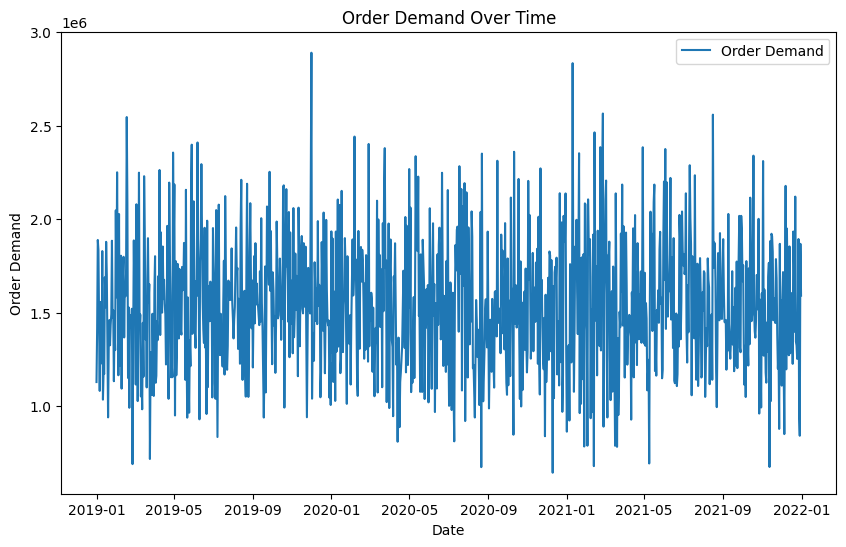

In [15]:
# Visualize the time series data
plt.figure(figsize=(10, 6))
plt.plot(df_daily['Date'], df_daily['Demand'], label='Order Demand')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.title('Order Demand Over Time')
plt.legend()
plt.show()

In [17]:
#Check stationarity using Augmented Dickey-Fuller test
result = adfuller(df_daily['Demand'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Differencing to make the data stationary if necessary
if result[1] > 0.05:
    df_daily['Demand_diff'] = df_daily['Demand'].diff().dropna()
    # Use the differenced series for ARIMA modeling
    series_to_use = df_daily['Demand_diff'].dropna()
else:
    series_to_use = df_daily['Demand']

# Define and fit ARIMA model
model = ARIMA(series_to_use, order=(5, 1, 0))  # Order: (p, d, q) - Adjust these values as needed
arima_result = model.fit()

# Print model summary
arima_result.summary()


ADF Statistic: -32.732230699217226
p-value: 0.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Demand   No. Observations:                 1096
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -15607.019
Date:                Sun, 15 Sep 2024   AIC                          31226.038
Time:                        16:43:24   BIC                          31256.029
Sample:                             0   HQIC                         31237.386
                               - 1096                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8244      0.029    -28.153      0.000      -0.882      -0.767
ar.L2         -0.6749      0.036    -18.674      0.000      -0.746      -0.604
ar.L3         -0.5104      0.040    -12.670      0.000      -0.589      -0.431
ar.L4         -0.3741      0.039     -9.554      0.000      -0.451      -0.297
ar.L5         -0.1702      0.031     -5.484      0.000      -0.231      -0.109
sigma2      1.392e+11   1.45e-14   9.61e+24      0.000    1.39e+11    1.39e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                17.87
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.31
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.43e+39. Standard errors may be unstable.
"""

In [20]:
# Forecast future values
forecast_steps = 30  # Number of days to forecast
forecast = arima_result.forecast(steps=forecast_steps)

forecast.head()

1096    1.466133e+06
1097    1.435399e+06
1098    1.322696e+06
1099    1.429082e+06
1100    1.527027e+06
Name: predicted_mean, dtype: float64

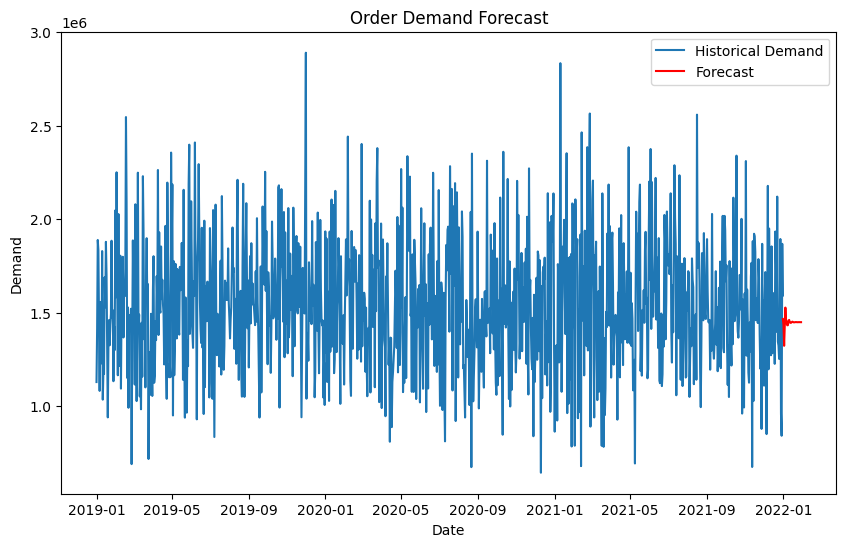

In [21]:
# Plot forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_daily['Date'], df_daily['Demand'], label='Historical Demand')
plt.plot(pd.date_range(start=df_daily['Date'].iloc[-1], periods=forecast_steps, freq='D'), forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Order Demand Forecast')
plt.legend()
plt.show()